## Login to Github API 

In [9]:
import getpass
url = "https://api.github.com/graphql"
github_apikey = getpass.getpass()
%store github_apikey
%store url

Stored 'github_apikey' (str)
Stored 'url' (str)


## Set repository and owner name

In [2]:
repo_name = input()
repo_owner = input()

%store repo_name
%store repo_owner

Stored 'repo_name' (str)
Stored 'repo_owner' (str)


In [14]:
%matplotlib inline
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import requests
sns.set(style="darkgrid")
%store -r github_apikey

%store -r repo_name
%store -r repo_owner
%store -r url


payload="{\"query\":\"{\\n  repository(name: \\\"repo_name\\\", owner: \\\"repo_owner\\\") {\\n    id\\n    isPrivate\\n    name\\n    owner {\\n      id\\n      login\\n      avatarUrl\\n    }\\n    createdAt\\n    releases(first: 10) {\\n      edges {\\n        node {\\n          id\\n          name\\n          createdAt\\n          publishedAt\\n tag {\\n          name\\n        }\\n       }\\n      }\\n    }\\n    \\n  }\\n}\\n\",\"variables\":{}}"

payload = payload.replace("repo_name", repo_name)
payload = payload.replace("repo_owner", repo_owner)

authorization_token = "Bearer {0}".format(github_apikey)
headers = {
  'Authorization': authorization_token,
  'Content-Type': 'application/json'
}

response = requests.request("POST", url, headers=headers, data=payload)
parsed_response = json.loads(response.text)["data"]["repository"]

releases = parsed_response["releases"]["edges"]
columns = ["Name", "Published at", "Created at"]
data = []

%store releases

for r in releases:
    release_node = r["node"]
    line = [release_node["tag"]["name"],release_node["publishedAt"],release_node["createdAt"]]
    data.append(line)

pd.DataFrame(data,columns=columns)


Stored 'releases' (list)


,Name,Published at,Created at
0,0.1.0,2021-02-11T00:10:38Z,2021-02-11T00:07:16Z
1,0.1.1,2021-02-11T00:16:40Z,2021-02-11T00:16:09Z
2,0.1.2,2021-02-11T17:46:59Z,2021-02-11T17:44:59Z
3,0.1.3,2021-02-15T18:31:36Z,2021-02-15T18:30:05Z
4,0.1.4,2021-02-15T18:37:27Z,2021-02-15T18:36:55Z
5,0.1.5,2021-02-15T18:44:05Z,2021-02-15T18:43:13Z
6,0.1.7,2021-03-17T18:13:56Z,2021-03-17T18:07:31Z
7,0.1.8,2021-03-17T18:36:19Z,2021-03-17T18:35:27Z
8,0.2.0,2021-03-23T17:47:08Z,2021-03-23T17:39:09Z
9,0.2.1,2021-04-05T17:08:02Z,2021-04-05T17:04:10Z


## Evolution of lead time for changes per release

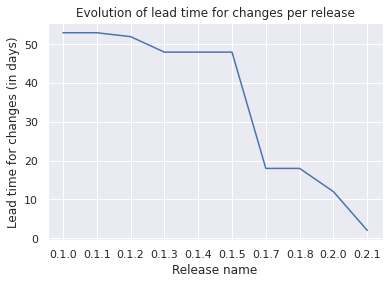

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from dateutil import parser as date_parser

%store -r github_apikey
%store -r repo_name
%store -r repo_owner
%store -r url
%store -r releases

releases_commits = dict()
leadtime_per_release = dict()

for r in releases:
    release_node = r["node"]
    delta_per_commit = []


    payload="{\"query\":\"{\\n  repository(name: \\\"repo_name\\\", owner: \\\"repo_owner\\\") {\\n    nameWithOwner\\n    object(expression: \\\"master\\\")   {\\n      ... on Commit {\\n        oid\\n        history(first: 100, since: \\\"since-date\\\") {\\n          nodes {\\n            oid\\n               messageHeadline\\n            author {\\n              user {\\n                login\\n              }\\n            }\\n            committedDate\\n           }\\n        }\\n      }\\n    }\\n  }\\n}\\n\",\"variables\":{}}"

    payload = payload.replace("repo_name", repo_name)
    payload = payload.replace("repo_owner", repo_owner)
    payload = payload.replace("repo_name", repo_name)
    payload = payload.replace("since-date", release_node["createdAt"])

    authorization_token = "Bearer {0}".format(github_apikey)

    headers = {
      'Authorization': authorization_token,
      'Content-Type': 'application/json'
    }

    response = requests.request("POST", url, headers=headers, data=payload)

    commits = json.loads(response.text)["data"]["repository"]["object"]["history"]["nodes"]
    release_date = date_parser.parse(release_node["publishedAt"], fuzzy=True)

    for c in commits:
        commit_date = date_parser.parse(c["committedDate"], fuzzy=True)
        delta = abs((commit_date-release_date).days)
        delta_per_commit.append(delta)
    
    np_array = np.array(delta_per_commit)
    median = np.median(np_array)
    leadtime_per_release[release_node["tag"]["name"]] = median

x = list(leadtime_per_release.keys())
y = list(leadtime_per_release.values())

x = np.array(x)
y = np.array(y)

plt.plot(x, y)
plt.xlabel("Release name")
plt.ylabel("Lead time for changes (in days)")
plt.title("Evolution of lead time for changes per release")  # add title
plt.show()